In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from tqdm.notebook import trange, tqdm

In [33]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Read Data

In [101]:
data = pd.read_excel('rawdata9.xlsx')
print(len(data.columns))
data.describe()

23


,Age,MA,Height,BMI,TC,pTS,TSW,KR,HR,AR,...,KEM,KAM,HEM,Habd,APF,AVM,HFM,WP,TS,DS
count,128.00000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,69.18750,10.389844,152.475781,26.690640,106.025141,86.491301,10.763516,49.682478,42.238809,25.098000,...,2.582926,3.862599,3.676134,4.946504,7.120335,0.731499,-2.655473,9.992188,94.122992,12.847505
std,5.73942,5.289491,5.679910,3.620793,11.742238,17.010802,3.317512,9.715327,6.667556,4.526451,...,1.509938,1.163509,1.152234,1.036143,1.067433,0.424240,0.973717,3.704639,13.339159,26.394219
min,54.00000,0.100000,135.600000,17.448710,69.993000,32.964000,3.240000,14.720611,17.978076,14.773579,...,0.282558,0.661710,1.023636,0.775936,1.741702,0.020159,-5.688691,2.000000,54.038500,-36.877917
25%,65.75000,6.300000,149.000000,24.459524,99.857125,74.270500,8.177250,46.223056,38.724445,22.122583,...,1.335410,3.104248,2.851841,4.485845,6.706076,0.424531,-3.181619,8.000000,86.441250,-4.636464
50%,69.50000,9.850000,151.950000,26.483930,107.571500,90.370250,10.758500,50.830833,42.860949,24.320379,...,2.539047,3.956699,3.647763,5.043076,7.202951,0.671263,-2.558914,10.000000,93.834500,7.430081
75%,73.00000,13.750000,156.000000,28.747782,113.774875,99.361500,12.843500,55.644528,46.233913,27.929313,...,3.506480,4.618037,4.254780,5.609077,7.737451,0.994911,-1.953276,12.000000,102.051875,24.142376
max,86.00000,27.300000,167.700000,37.385703,145.247500,113.532000,23.090000,71.238870,60.056088,38.085972,...,9.080355,6.765972,7.004215,8.081029,9.336282,2.470504,-0.769589,20.000000,133.825000,102.450330


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     128 non-null    int64  
 1   MA      128 non-null    float64
 2   Height  128 non-null    float64
 3   BMI     128 non-null    float64
 4   TC      128 non-null    float64
 5   pTS     128 non-null    float64
 6   TSW     128 non-null    float64
 7   KR      128 non-null    float64
 8   HR      128 non-null    float64
 9   AR      128 non-null    float64
 10  PT      128 non-null    float64
 11  KC      128 non-null    float64
 12  HC      128 non-null    float64
 13  KEM     128 non-null    float64
 14  KAM     128 non-null    float64
 15  HEM     128 non-null    float64
 16  Habd    128 non-null    float64
 17  APF     128 non-null    float64
 18  AVM     128 non-null    float64
 19  HFM     128 non-null    float64
 20  WP      128 non-null    int64  
 21  TS      128 non-null    float64
 22  DS

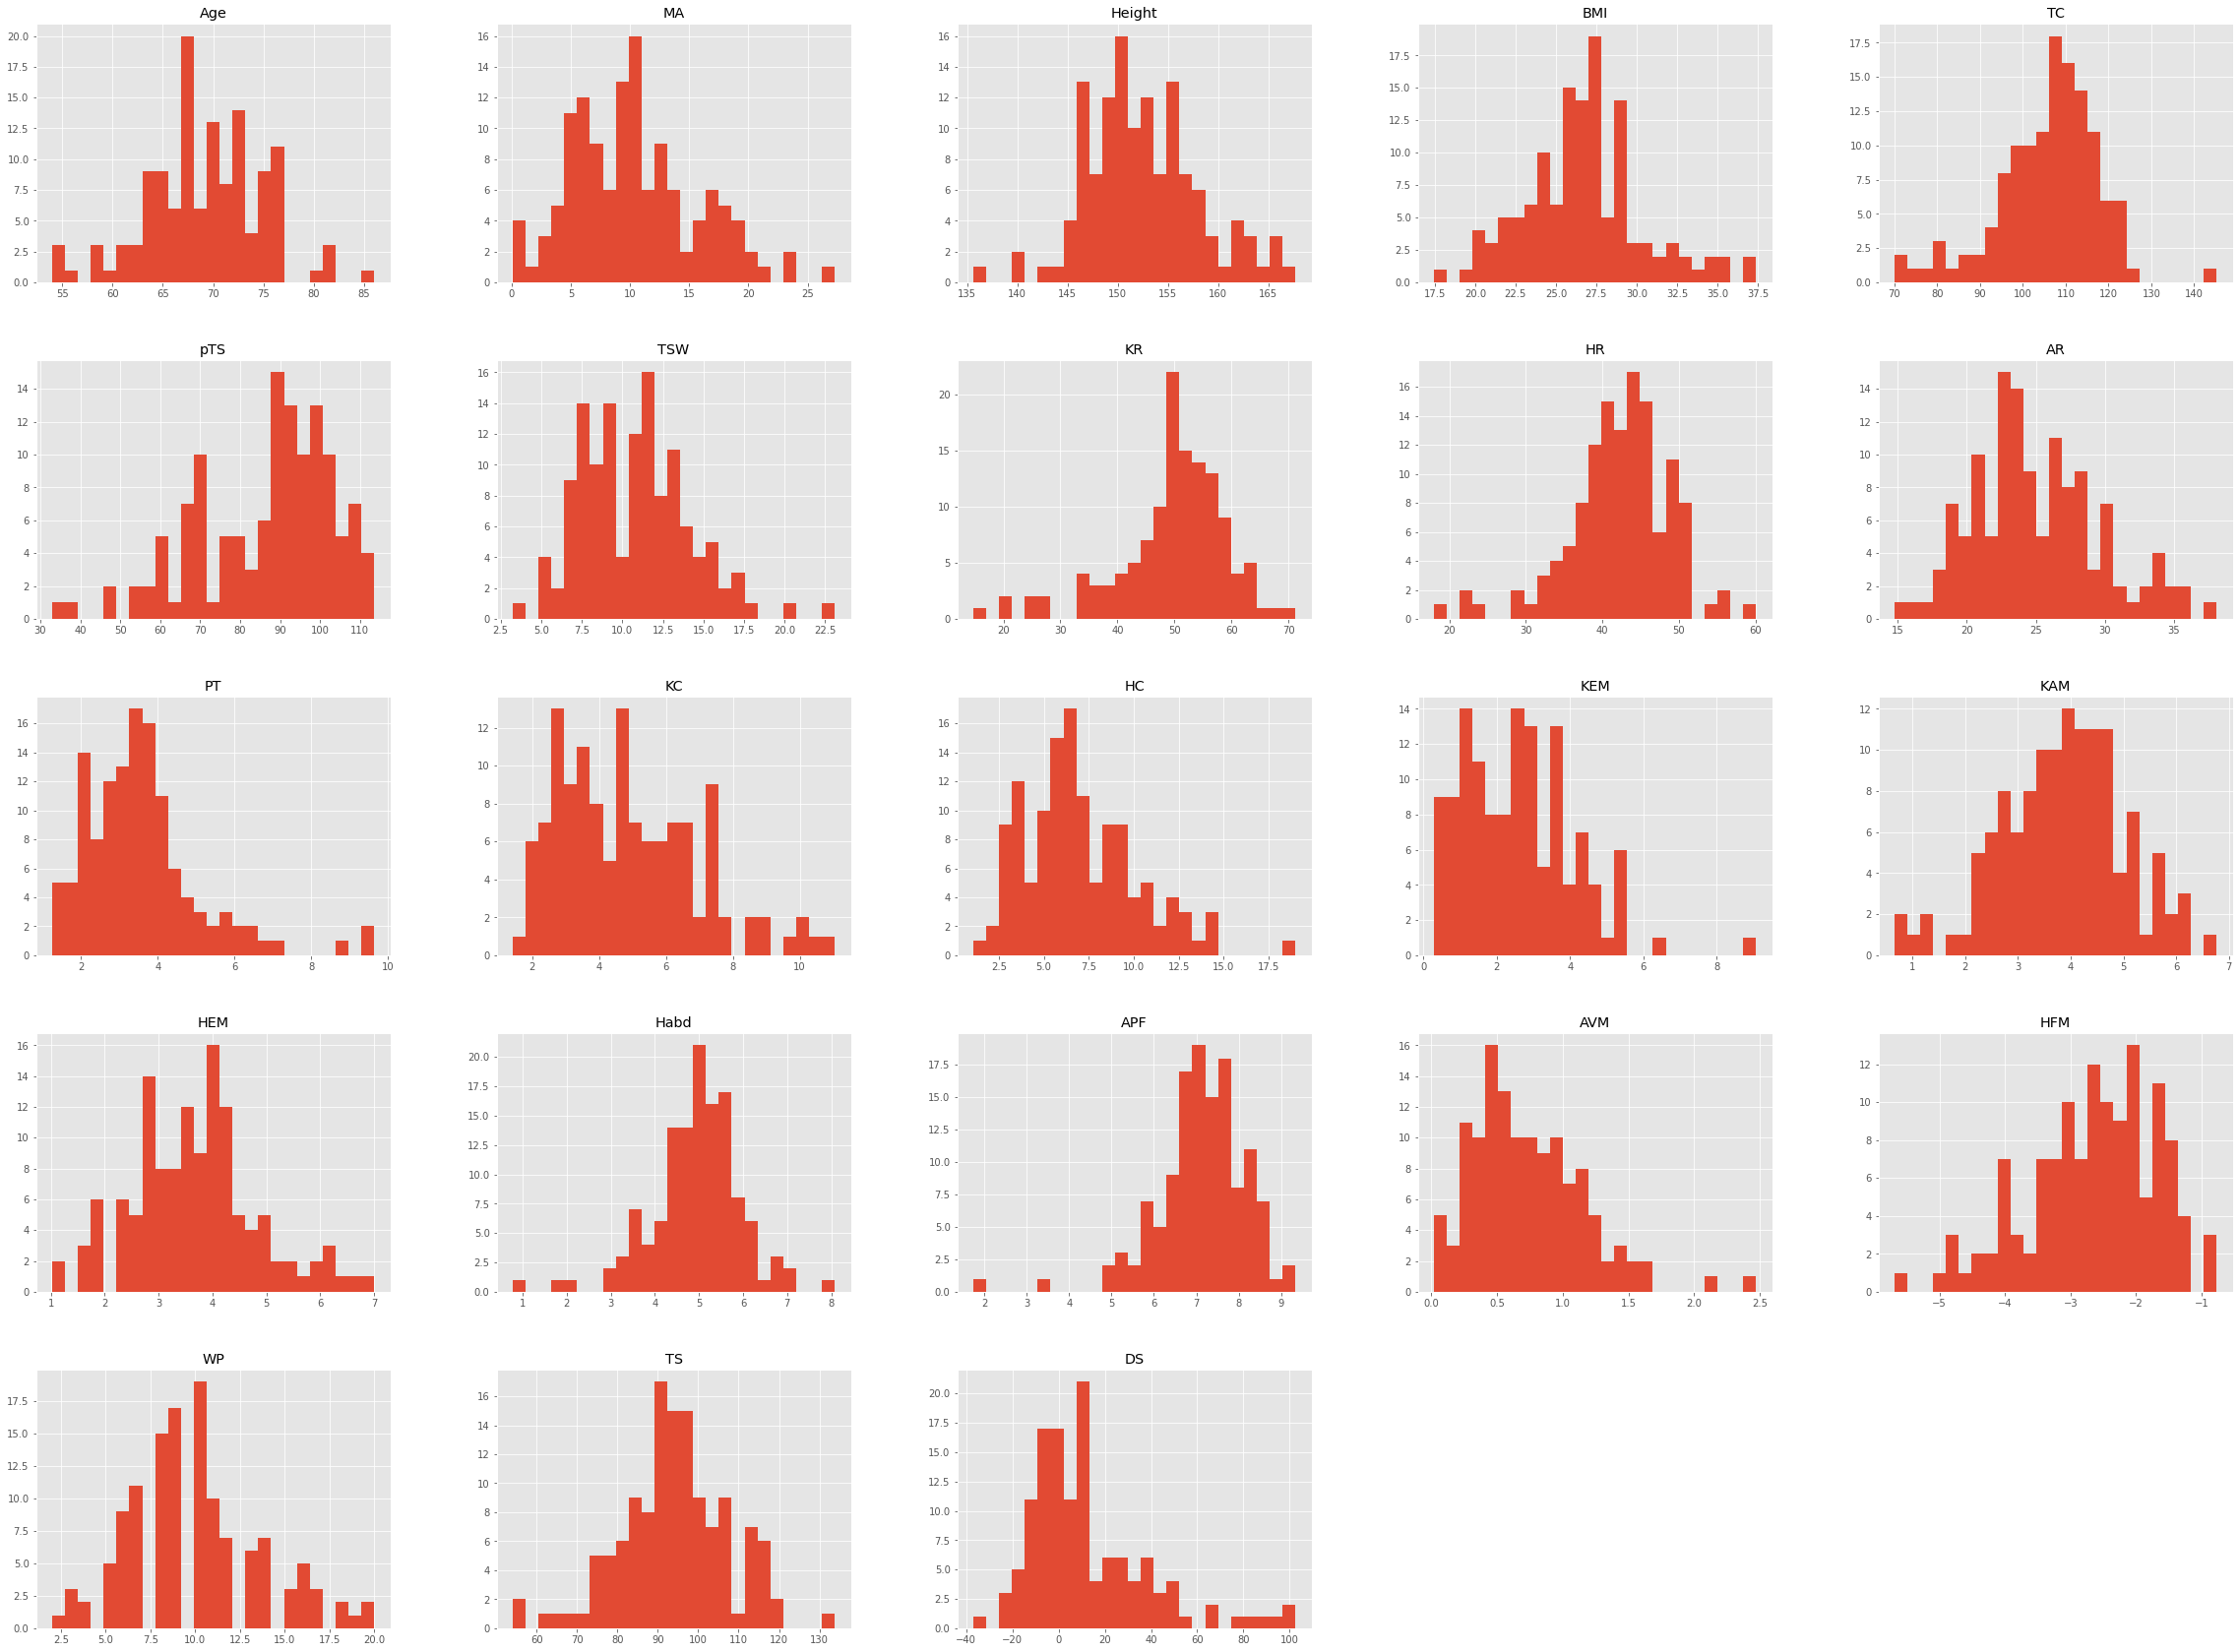

In [36]:
plt.style.use('ggplot')
data.hist(bins=25, figsize=(40,30));

# Output 변수 탐색

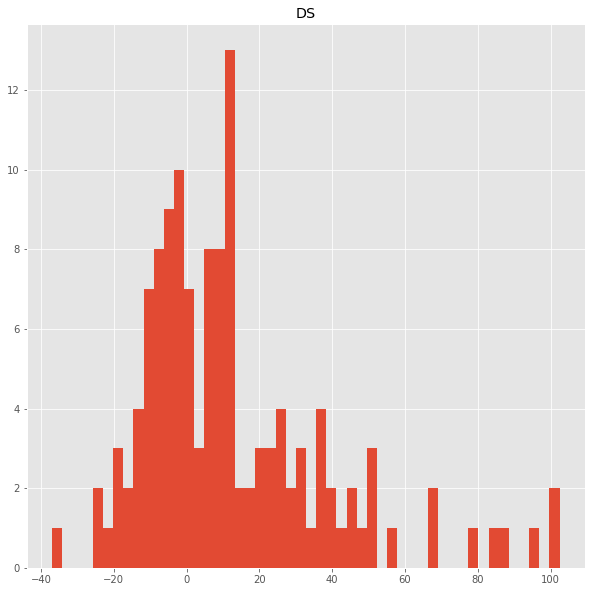

In [37]:
data[['DS']].hist(bins=50, figsize=(10,10))
plt.show()

In [55]:
threshold = range(-20, 20)
train_acc = []
train_auc = []
test_acc = []
test_auc = []

for i in tqdm(range(-20,20)):
    arr = np.array([i])

    data['DS(cat)'] = arr.searchsorted(data['DS'])

    X = data.drop(['TS', 'DS','DS(cat)'], axis=1)
    X = preprocessing.StandardScaler().fit_transform(X)
    y = data['DS(cat)']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    clf = GradientBoostingClassifier()
    clf.fit(X_train,y_train)
    
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    train_acc.append(scores.mean())
    
    scores = cross_val_score(clf, X_train, y_train, cv=3,scoring='roc_auc')
    train_auc.append(scores.mean())

    y_pred = clf.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred))

    y_score = clf.predict_proba(X_test)
    test_auc.append(roc_auc_score(y_test, y_score[:, 1]))

  0%|          | 0/40 [00:00<?, ?it/s]

<Axes: xlabel='threshold'>

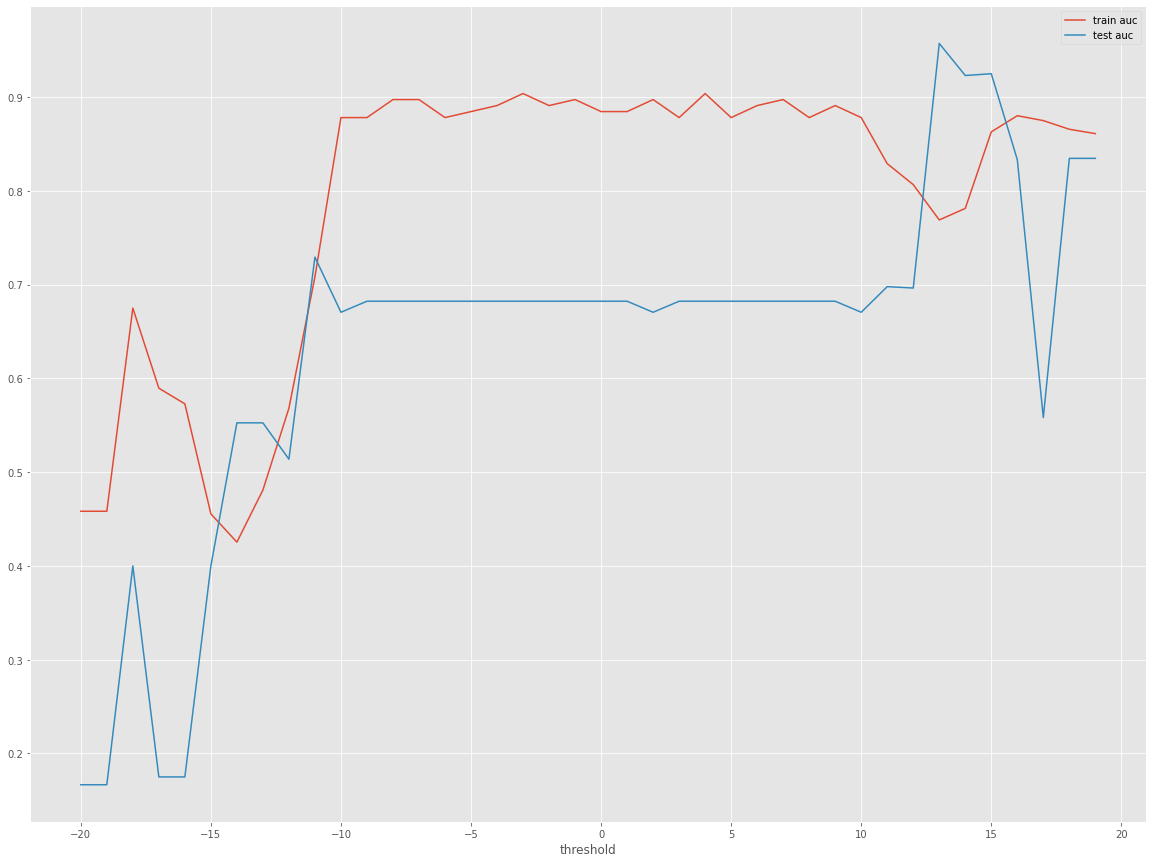

In [56]:
plt.rcParams["figure.figsize"] = (20,15)
df = pd.DataFrame()
# df['train acc'] = train_acc
df['train auc'] = train_auc
# df['test acc'] = test_acc
df['test auc'] = test_auc
df['threshold'] = threshold
df.set_index('threshold', drop=True, inplace=True)
df.plot.line()

# Output 변수 categorization

In [103]:
arr = np.array([-10, 10])

data['exclude'] = arr.searchsorted(data['DS'])

In [104]:
data = data[data.exclude != 1]

In [105]:
data.drop(['exclude'], axis=1, inplace=True)

In [106]:
arr = np.array([0])

data['DS(cat)'] = arr.searchsorted(data['DS'])

X = data.drop(['TS', 'DS(cat)', 'DS'], axis=1)
X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X), columns=list(X))
y = data['DS(cat)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)

GradientBoostingClassifier()

# Feature selection

### RFE

In [61]:
'''from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

rfecv = RFECV(estimator = clf, step = 1, cv = StratifiedKFold(3), scoring = 'roc_auc', n_jobs = -1)

rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features")
plt.ylabel("AUROC")
plt.title('Recursive Feature Elimination')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()'''

'from sklearn.feature_selection import RFECV\nfrom sklearn.model_selection import StratifiedKFold\n\nrfecv = RFECV(estimator = clf, step = 1, cv = StratifiedKFold(3), scoring = \'roc_auc\', n_jobs = -1)\n\nrfecv.fit(X_train, y_train)\n\nprint("Optimal number of features : %d" % rfecv.n_features_)\n\n# Plot number of features VS. cross-validation scores\nplt.figure()\nplt.xlabel("Number of features")\nplt.ylabel("AUROC")\nplt.title(\'Recursive Feature Elimination\')\nplt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)\nplt.show()'

### Sequential selection

In [62]:
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import StratifiedKFold

start = 1
end = 22

k_fold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

### Sequential Forward Selection

In [63]:
sfs = SequentialFeatureSelector(clf,
           k_features=(start, end - 1),
           forward=True,
           floating=False,
           verbose=0,
           scoring='roc_auc',
           cv=k_fold,
           n_jobs=-1)

sfs.fit(X_train, y_train)

index_total = []
index_num_total = []
auc_total = []

for i in range(start, end):
    index = [list(X)[i] for i in sfs.subsets_[i]['feature_idx']]
    index_num = list(sfs.subsets_[i]['feature_idx'])
    index_total.append(index)
    index_num_total.append(index_num)
    auc_total.append(sfs.subsets_[i]['avg_score'])

pd.set_option('max_colwidth', 500)
pd.DataFrame(zip(auc_total, index_total, index_num_total), index=range(start, end), columns=['auc', 'features', 'col_no'])

,auc,features,col_no
1,0.806250,[pTS],[5]
2,0.875000,"[MA, pTS]","[1, 5]"
3,0.925000,"[Age, MA, pTS]","[0, 1, 5]"
4,0.933333,"[Age, MA, pTS, AVM]","[0, 1, 5, 18]"
5,0.933333,"[Age, MA, pTS, AVM, HFM]","[0, 1, 5, 18, 19]"
6,0.908333,"[Age, MA, pTS, APF, AVM, HFM]","[0, 1, 5, 17, 18, 19]"
7,0.908333,"[Age, MA, pTS, HR, APF, AVM, HFM]","[0, 1, 5, 8, 17, 18, 19]"
8,0.833333,"[Age, MA, Height, pTS, HR, APF, AVM, HFM]","[0, 1, 2, 5, 8, 17, 18, 19]"
9,0.850000,"[Age, MA, Height, pTS, HR, KEM, APF, AVM, HFM]","[0, 1, 2, 5, 8, 13, 17, 18, 19]"
10,0.833333,"[Age, MA, Height, pTS, HR, KC, KEM, APF, AVM, HFM]","[0, 1, 2, 5, 8, 11, 13, 17, 18, 19]"


그림 저장: Sequential Forward Selection


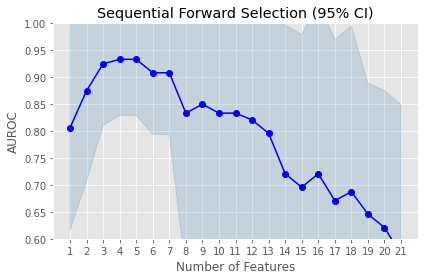

In [64]:
fig1 = plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(6, 4))

plt.ylim([0.6, 1])
plt.title('Sequential Forward Selection (95% CI)')
plt.ylabel('AUROC')
save_fig("Sequential Forward Selection")
plt.show()

# Select Features

In [107]:
X_train_original = X_train
X_test_original = X_test

In [108]:
index = [0,1,5]
print([list(X_train_original)[i] for i in index])
X_train = X_train_original.iloc[:, index]
X_test = X_test_original.iloc[:, index]

['Age', 'MA', 'pTS']


# ROC curve (internal)

len_y_true: 6, len_y_pred: 6, len_fpr: 4, len_tpr: 4
len_y_true: 5, len_y_pred: 5, len_fpr: 6, len_tpr: 6
len_y_true: 5, len_y_pred: 5, len_fpr: 4, len_tpr: 4
len_y_true: 5, len_y_pred: 5, len_fpr: 4, len_tpr: 4
len_y_true: 5, len_y_pred: 5, len_fpr: 4, len_tpr: 4
len_y_true: 5, len_y_pred: 5, len_fpr: 5, len_tpr: 5
len_y_true: 5, len_y_pred: 5, len_fpr: 4, len_tpr: 4
len_y_true: 5, len_y_pred: 5, len_fpr: 2, len_tpr: 2
len_y_true: 5, len_y_pred: 5, len_fpr: 4, len_tpr: 4
len_y_true: 5, len_y_pred: 5, len_fpr: 4, len_tpr: 4
그림 저장: Figure 2B


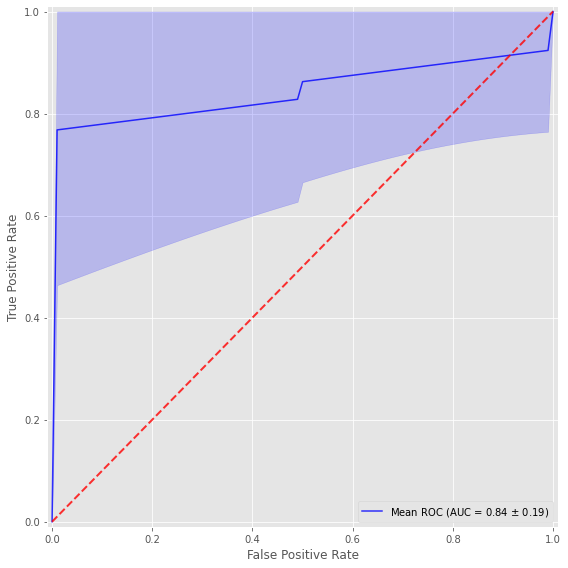

In [109]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

thresholds = []
tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 101)

for train, test in skfolds.split(X_train, y_train):
    
    model = clf.fit(X_train.iloc[train], y_train.iloc[train])
    
    y_score = model.predict_proba(X_train.iloc[test])
    
    fpr, tpr, threshold = roc_curve(y_train.iloc[test], y_score[:, 1])
    print(f'len_y_true: {len(y_train.iloc[test])}, len_y_pred: {len(y_score[:, 1])}, len_fpr: {len(fpr)}, len_tpr: {len(tpr)}')
    
    roc_auc = auc(fpr, tpr)
    
    aucs.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    threshold = interp(base_fpr, fpr, threshold)
    thresholds.append(threshold)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
# plt.title('Receiver operating characteristic (ROC) curve')
save_fig('Figure 2B')
plt.show()

# Youden index, sensitivity, specificity

In [110]:
youden_index = mean_tprs-base_fpr
max_index = np.argmax(youden_index)
sensitivity = mean_tprs[max_index]
specificity = 1 - base_fpr[max_index]
print("max youden index", youden_index[max_index],"thresholds", mean_thresholds[max_index], "sensitivity", sensitivity, "specificity", specificity)

max youden index 0.7579166666666666 thresholds 1.0909825364527939 sensitivity 0.7679166666666666 specificity 0.99


# Feature importance

그림 저장: Figure 2A


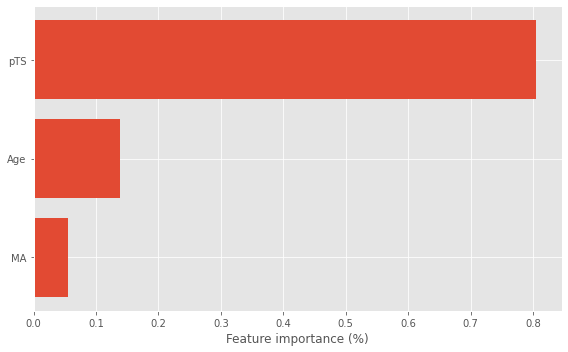

In [111]:
clf.feature_importances_
feature_importance_dict = {k: v for k, v in sorted(dict(zip(X_train, clf.feature_importances_)).items(), key=lambda item: item[1], reverse=True)}

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,5))
fig.align_ylabels()

feature = feature_importance_dict.keys()
y_pos = np.arange(len(feature))
feature_importance = feature_importance_dict.values()

ax.barh(y_pos, feature_importance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance (%)')
save_fig('Figure 2A')

# Validation

In [112]:
y_test_score = clf.predict_proba(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_test_score[:, 1])

roc_auc = auc(fpr, tpr)

그림 저장: Figure 2C


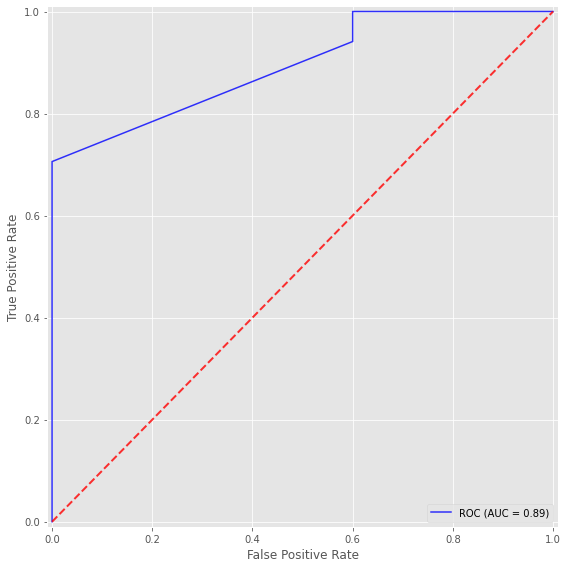

In [113]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, 'b', alpha = 0.8, label = r'ROC (AUC = %0.2f)' % (roc_auc),)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
#plt.title('Receiver operating characteristic (ROC) curve')
save_fig('Figure 2C')
plt.show()

In [114]:
youden_index = tpr - fpr
max_index = np.argmax(youden_index)
sensitivity = tpr[max_index]
specificity = 1 - fpr[max_index]
print(f'max youden index: {youden_index[max_index]:.03f}, thresholds: {threshold[max_index]:.03f}, sensitivity: {sensitivity:.03f}, specificity: {specificity:.03f}')

max youden index: 0.706, thresholds: 1.000, sensitivity: 0.706, specificity: 1.000
